# Part 1

In [139]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [140]:
from numba import cuda

import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image
import cv2
import math
import operator
print(cuda.gpus)

<Managed Device 0>


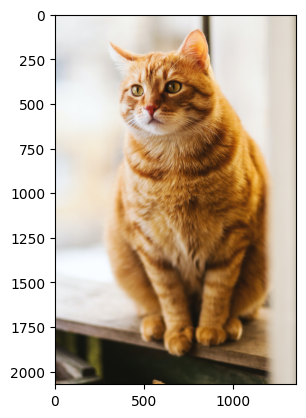

In [141]:
cell_size = (8, 8)
block_size = (2, 2)
img = Image.open('drive/MyDrive/ltssud/cat-1.jpg')
new_width  =  img.size[0] // cell_size[0] * cell_size[0]
new_height =  img.size[1] // cell_size[1] * cell_size[1]
img = img.resize((new_width,new_height), Image.LANCZOS)
# img = img.resize((64,128), Image.LANCZOS)
pixel = np.array(img)
plt.imshow(pixel)

In [142]:
height, width, channel = pixel.shape
print("Height: {0}\nWidth: {1}\nChannel: {2}".format(height,width,channel))

Height: 2072
Width: 1352
Channel: 3


In [143]:
def gray_host(input, channel):
    if channel==1:
        return
    return 0.299*input[:,:,0]+0.587*input[:,:,1]+0.114*input[:,:,2]

In [144]:
gray_host = gray_host(pixel, channel)

In [145]:
@cuda.jit
def gray_kernel(picture_in, gray_out):    
    row, col = cuda.grid(2)
    image_rows, image_cols,channel = picture_in.shape
    if (row >= image_rows) or (col >= image_cols): 
        return
    rgb                = picture_in[row][col]
    gray_out[row][col] = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    # assuming x and y inputs are same length

In [146]:
# Memory Allocation
gray_dev   = np.empty([pixel.shape[0], pixel.shape[1]],dtype = float)
x_device   = cuda.to_device(pixel)
gray_device = cuda.device_array_like(gray_dev)

In [147]:
block_size = (32, 32)

grid_size = (math.ceil(height/block_size[0]), math.ceil(width/block_size[1]))

gray_kernel[grid_size, block_size](x_device, gray_device)

In [148]:
gray_dev = gray_device.copy_to_host()

In [149]:
np.sum(np.subtract(gray_dev, gray_host))

-1.2079262035058491e-09

In [150]:
sobel_x = np.array([-1,0,1])
sobel_y = np.array([[-1],
                    [0],
                    [1]])

# [0] là theo trục y, [1] là theo trục x
cell_size = (8, 8)
block_hog_size = (2, 2)
hist_size = 9

height, width, channel = pixel.shape

n_cell = (height//cell_size[0], width//cell_size[1])
n_block = (n_cell[0] - block_hog_size[0] + 1, n_cell[1] - block_hog_size[1] + 1)
print(n_cell,n_block)

(259, 169) (258, 168)


In [151]:
def calc_gradient(input, width, height):
  output_x = np.zeros((height,width))
  output_y = np.zeros((height,width))

  for r in range(height):
    for c in range(width):

      for i in range(-1,2):
        pixel_r = r + i
        pixel_r = min(max(0, pixel_r), height - 1)
        output_y[r,c] += input[pixel_r,c] * i

        pixel_c = c + i
        pixel_c = min(max(0, pixel_c), width - 1)
        output_x[r,c] += input[r,pixel_c] * i

  return output_x, output_y

In [152]:
gradient_x, gradient_y = calc_gradient(gray_dev, width, height)

In [153]:
@cuda.jit
def calc_gradient_kernel(input, width, height, output_x, output_y):
  row, col = cuda.grid(2)
  if (row>=height) or (col>=width):
    return
  for i in range(-1,2):
    pixel_r = row + i
    pixel_r = min(max(0, pixel_r), height - 1)
    output_y[row, col] += input[pixel_r,col] * i

    pixel_c = col + i
    pixel_c = min(max(0, pixel_c), width - 1)
    output_x[row,col] += input[row,pixel_c] * i

In [154]:
gradient_x_dev = np.zeros((height, width))
gradient_y_dev = np.zeros((height, width))

gradient_x_device = cuda.to_device(gradient_x_dev)
gradient_y_device = cuda.to_device(gradient_y_dev)

In [155]:
calc_gradient_kernel[grid_size, block_size]\
(gray_device, width, height, gradient_x_device, gradient_y_device)

In [156]:
gradient_x_dev = gradient_x_device.copy_to_host()
gradient_y_dev = gradient_y_device.copy_to_host()

In [157]:
np.sum(np.subtract(gradient_x_dev, gradient_x))

0.0

In [158]:
np.sum(np.subtract(gradient_y_dev, gradient_y))

0.0

In [159]:
magnitude = np.sqrt(np.square(gradient_x_dev)+np.square(gradient_y_dev))

In [160]:
direction = np.mod(np.add(360, np.rad2deg(np.arctan2(np.array(gradient_y_dev), np.array(gradient_x_dev)))), 360)

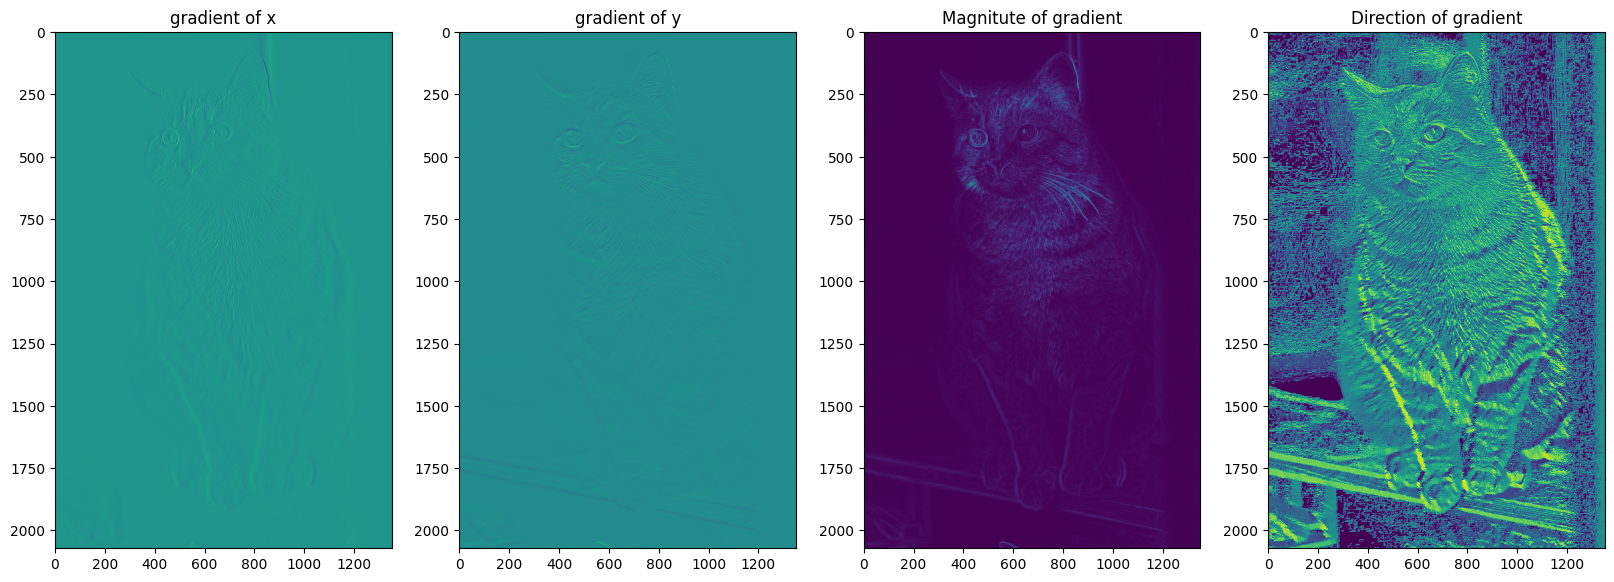

In [161]:
w = 20
h = 10

plt.figure(figsize=(w, h))
plt.subplot(1, 4, 1)
plt.title('gradient of x')
plt.imshow(gradient_x)

plt.subplot(1, 4, 2)
plt.title('gradient of y')
plt.imshow(gradient_y)

plt.subplot(1, 4, 3)
plt.title('Magnitute of gradient')
plt.imshow(magnitude)

plt.subplot(1, 4, 4)
plt.title('Direction of gradient')
plt.imshow(direction)

In [162]:
def cell_hist(direction, magnitude, idx, idy, width, height, cell_size, sbin):
    output = np.zeros(9) # output = [0,0,0,0,0,0,0,0,0]
    
    # duyệt qua kích thước cell theo chiều cao
    for r in range(cell_size[0]):
      # duyệt qua kích thước cell theo chiều rộng
        for c in range(cell_size[1]):
          # cột và dòng hiện tại trong ảnh
            cur_r = idy*cell_size[0] + r
            cur_c = idx*cell_size[1] + c
            # kiểm tra
            if cur_r>=height or cur_c >= width:
                break

            # chia lấy phần nguyên và phần dư
            quotient = int(direction[cur_r][cur_c]//sbin)
            remainder = direction[cur_r][cur_c] % sbin

            if remainder==0:
                output[quotient] += magnitude[cur_r][cur_c]
            else:
                first_bin = quotient

                second_bin = first_bin+1

                output[first_bin] += magnitude[cur_r][cur_c]*\
                    ((second_bin*sbin - direction[cur_r][cur_c])/(second_bin*sbin - first_bin*sbin))
                    
                second_bin_idx = second_bin
                if second_bin > 8:
                    second_bin_idx = 0
                output[second_bin_idx] += magnitude[cur_r][cur_c]*\
                    ((direction[cur_r][cur_c] - first_bin*sbin)/(second_bin*sbin - first_bin*sbin))
    return output

In [163]:
hist = []

for y in range(0,n_cell[0]):
    row = []
    for x in range(0,n_cell[1]):
        output = cell_hist(direction,magnitude,x,y,width,height,cell_size,40)
        row.append(output)
    hist.append(row)
hist = np.array(hist)
print(hist.shape)
print(n_cell)
print(hist.dtype)

(259, 169, 9)
(259, 169)
float64


In [164]:
@cuda.jit
def hist_kernel(direction, magnitude, cell_size, d_sbin, result_out):    
    cur_r, cur_c  = cuda.grid(2)
    height, width = direction.shape
    
    idy   = int(cur_r//cell_size[0])
    idx   = int(cur_c//cell_size[1])
    sbin  = d_sbin[0] 
    # kiểm tra
    if cur_r>=height or cur_c>= width:
        return 
    thread_direction = direction[cur_r][cur_c]
    thread_mag       = magnitude[cur_r][cur_c]
    # chia lấy phần nguyên và phần dư
    quotient  = int(thread_direction//sbin)
    remainder =     thread_direction % sbin

    if remainder==0:
        cuda.atomic.add(result_out, (idy, idx, quotient), thread_mag)
    else:
        first_bin = quotient

        second_bin   = first_bin+1
        need_to_add    = thread_mag*((second_bin*sbin - thread_direction)/(second_bin*sbin - first_bin*sbin))
        cuda.atomic.add(result_out, (idy, idx, first_bin), need_to_add)
        
        second_bin_idx = second_bin
        if second_bin > 8:
            second_bin_idx = 0
        need_to_add_2  = thread_mag*((thread_direction - first_bin*sbin)/(second_bin*sbin - first_bin*sbin))   
        cuda.atomic.add(result_out, (idy, idx, second_bin_idx), need_to_add_2)

In [165]:
# Memory Allocation
out_hist      = np.empty([n_cell[0], n_cell[1], 9],dtype = np.float64)
d_direction   = cuda.to_device(direction)
d_magnitude   = cuda.to_device(magnitude)
d_cell_size   = cuda.to_device(cell_size)
d_sbin        = cuda.to_device([40])
out_device_hist    = cuda.device_array_like(out_hist)

In [166]:
threadsperblock = (32, 32)
blockspergrid_x = math.ceil(direction.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(direction.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)
hist_kernel[blockspergrid, threadsperblock](d_direction, d_magnitude, d_cell_size, d_sbin, out_device_hist)

In [167]:
test = out_device_hist.copy_to_host()

In [168]:
CUDA = test.flatten()

In [169]:
CPU = hist.flatten()

In [170]:
np.mean(np.abs(CUDA - CPU))

4.710827293809443e-15

# Current

In [178]:
# [0] là theo trục y, [1] là theo trục x
cell_size = (8, 8)
block_hog_size = (2, 2)
hist_size = 9

height, width, channel = pixel.shape

n_cell = (height//cell_size[0], width//cell_size[1])
n_block = (n_cell[0] - block_hog_size[0] + 1, n_cell[1] - block_hog_size[1] + 1)
print(n_cell,n_block)

(259, 169) (258, 168)


In [171]:
norm_array_size = n_block[0] * n_block[1] * block_hog_size[0] * block_hog_size[1] * hist_size

In [172]:
hist.shape

(259, 169, 9)

In [173]:
norm_block = np.zeros((norm_array_size,))
norm_idx = 0
for y in range(n_block[0]):
    for x in range(n_block[1]):
        k = math.sqrt(np.sum(np.square(hist[y:y + 2, x: x + 2])))
        out = hist[y: y + 2, x: x + 2] / (k + 1)
        out = out.reshape(block_hog_size[0]*block_hog_size[1]*hist_size)
        norm_block[norm_idx:norm_idx + block_hog_size[0]*block_hog_size[1]*hist_size] += out
        norm_idx += block_hog_size[0]*block_hog_size[1]*hist_size

In [174]:
from skimage import feature
H = feature.hog(gray_dev, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2")

print('Kích thước hog features: ', H.shape)

Kích thước hog features:  (1560384,)


In [176]:
b = H.reshape(H.shape)

In [177]:
np.mean(np.abs(norm_block - b))

0.11174188874999015